# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

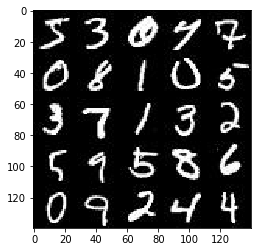

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

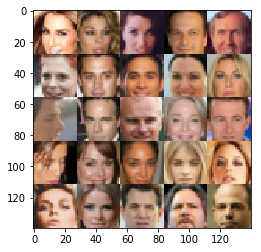

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # create placeholders for data and learn rate
    input_data = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="input_images")
    z_data = tf.placeholder(tf.float32, shape=(None, z_dim), name="z_data")
    lr = tf.placeholder(tf.float32, shape=(), name="learn_rate")

    return input_data, z_data, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def leaky_relu(x, alpha):
    """
    leaky relu func as TF doesnt have a built in one
    """
    return tf.maximum(alpha * x, x)

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha = 0.12    
   
    x = images    
    
    # use xavier to set weights to smaller amount
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    use_dropout = False
    
    with tf.variable_scope("discriminator", reuse=reuse): 
        
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same', kernel_initializer=kernel_init)
        #x1 = tf.layers.batch_normalization(x1, training=True) # no batch norm on first layer
        x1 = leaky_relu(x1, alpha)
        if use_dropout:
            x1 = tf.nn.dropout(x1, 0.9)
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same', kernel_initializer=kernel_init)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = leaky_relu(x2, alpha)
        if use_dropout:
            x2 = tf.nn.dropout(x2, 0.9)
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', kernel_initializer=kernel_init)
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = leaky_relu(x3, alpha)
        if use_dropout:
            x3 = tf.nn.dropout(x3, 0.9)
    
        # tack on fc layer
        n_units = int(x3.shape[1] * x3.shape[2] * x3.shape[3])
        
        #flatten out
        fl = tf.reshape(x3, [-1, n_units])
        
        logits = tf.layers.dense(fl, 1)
        
        # sigmoid activation
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
   
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.2
    
    reuse = not is_train  
    
    #use xavier for sensible weight init
    kernel_init = tf.contrib.layers.xavier_initializer()
    
    alt_model_version = True
   
    with tf.variable_scope("generator", reuse=reuse):
    
        if alt_model_version:
            # flat input layer
            x1 = tf.layers.dense(z, 7*7*512)
            
            # reshape x1 to begin inverse convolution
            x1 = tf.reshape(x1, (-1, 7, 7, 512))
        
        else:
            # flat input layer
            x1 = tf.layers.dense(z, units=3*3*512, activation=None)
        
            # reshape x1 to begin inverse convolution
            x1 = tf.reshape(x1, (-1, 3, 3, 512))
            
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = leaky_relu(x1, alpha)
        
        #print(x1.shape)
        
        if alt_model_version:
            x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=2, padding='same', kernel_initializer=kernel_init)
        else:
            x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding='valid', kernel_initializer=kernel_init)
        
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = leaky_relu(x2, alpha)
        
        #print(x2.shape)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same', kernel_initializer=kernel_init)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = leaky_relu(x3, alpha)
        
        #print(x3.shape)
        
        # output layer...
        
        if alt_model_version:
            logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=1, padding='same')
        else:
            logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 3, strides=2, padding='same', kernel_initializer=kernel_init)
        
        
        #print(logits.shape)
      
        out = tf.nn.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    smooth = 0.1 # smooth the ones to help training per Udacity advice
    
    # Generator network:

    g_model = generator(input_z, out_channel_dim, is_train=True)


    # Disriminator network:
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # Calculate losses
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real,
                                                                         labels=tf.ones_like(d_logits_real) * (1-smooth)))

    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                         labels=tf.zeros_like(d_logits_fake)))

    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    all_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    g_update_ops = [var for var in all_update_ops if var.name.startswith('generator')]
    d_update_ops = [var for var in all_update_ops if var.name.startswith('discriminator')]

    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Build Model    
    
    inputs_real, inputs_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[-1])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    #used to throttle output
    counter=0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                # Get images, reshape and rescale to pass to D
                counter = counter+1
                batch_images = batch_images * 2

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, lr:learning_rate})
                
               
                if counter % 20 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = sess.run(d_loss, {inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))    

                if counter % 100 == 0:
                    show_generator_output(sess, 25, inputs_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5228... Generator Loss: 2.4635
Epoch 1/2... Discriminator Loss: 0.3820... Generator Loss: 3.7396
Epoch 1/2... Discriminator Loss: 0.3471... Generator Loss: 5.2337
Epoch 1/2... Discriminator Loss: 0.5057... Generator Loss: 2.2602
Epoch 1/2... Discriminator Loss: 0.6851... Generator Loss: 1.5388


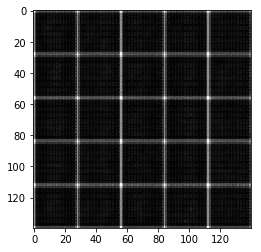

Epoch 1/2... Discriminator Loss: 0.7689... Generator Loss: 1.6129
Epoch 1/2... Discriminator Loss: 0.5666... Generator Loss: 4.9760
Epoch 1/2... Discriminator Loss: 0.6969... Generator Loss: 2.8707
Epoch 1/2... Discriminator Loss: 0.8779... Generator Loss: 1.5334
Epoch 1/2... Discriminator Loss: 0.5778... Generator Loss: 2.1990


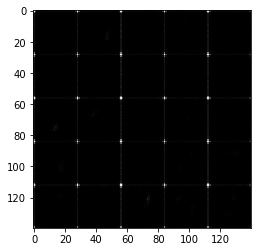

Epoch 1/2... Discriminator Loss: 0.9162... Generator Loss: 1.9464
Epoch 1/2... Discriminator Loss: 0.6828... Generator Loss: 2.5869
Epoch 1/2... Discriminator Loss: 0.7082... Generator Loss: 1.9768
Epoch 1/2... Discriminator Loss: 0.7987... Generator Loss: 3.1314
Epoch 1/2... Discriminator Loss: 0.8693... Generator Loss: 2.0412


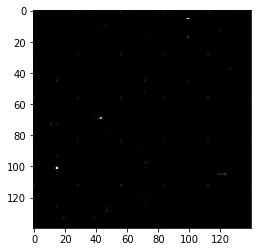

Epoch 1/2... Discriminator Loss: 1.1019... Generator Loss: 1.3346
Epoch 1/2... Discriminator Loss: 0.5334... Generator Loss: 2.7982
Epoch 1/2... Discriminator Loss: 0.8578... Generator Loss: 1.8456
Epoch 1/2... Discriminator Loss: 0.5543... Generator Loss: 2.4607
Epoch 1/2... Discriminator Loss: 0.7322... Generator Loss: 2.0878


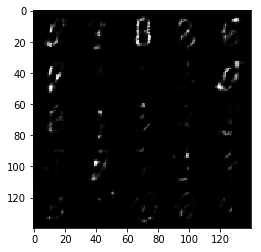

Epoch 1/2... Discriminator Loss: 0.6050... Generator Loss: 2.1240
Epoch 1/2... Discriminator Loss: 0.6013... Generator Loss: 2.3360
Epoch 1/2... Discriminator Loss: 0.9329... Generator Loss: 1.4588
Epoch 1/2... Discriminator Loss: 0.8430... Generator Loss: 1.7895
Epoch 1/2... Discriminator Loss: 0.7356... Generator Loss: 2.6367


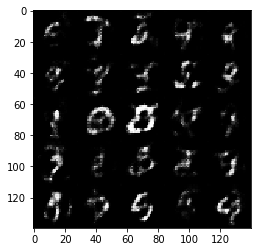

Epoch 1/2... Discriminator Loss: 0.9748... Generator Loss: 2.9603
Epoch 1/2... Discriminator Loss: 0.5996... Generator Loss: 2.1708
Epoch 1/2... Discriminator Loss: 0.8131... Generator Loss: 2.3585
Epoch 1/2... Discriminator Loss: 0.6249... Generator Loss: 2.1049
Epoch 1/2... Discriminator Loss: 0.5534... Generator Loss: 2.7902


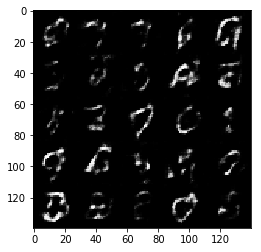

Epoch 1/2... Discriminator Loss: 0.5342... Generator Loss: 2.9594
Epoch 1/2... Discriminator Loss: 0.5102... Generator Loss: 2.9905
Epoch 1/2... Discriminator Loss: 0.8130... Generator Loss: 2.5055
Epoch 1/2... Discriminator Loss: 0.6831... Generator Loss: 2.1984
Epoch 1/2... Discriminator Loss: 0.6338... Generator Loss: 2.4060


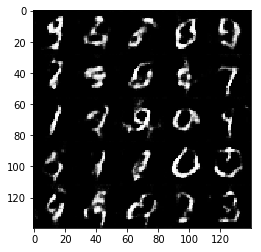

Epoch 1/2... Discriminator Loss: 0.6702... Generator Loss: 2.1162
Epoch 1/2... Discriminator Loss: 0.5256... Generator Loss: 2.6007
Epoch 1/2... Discriminator Loss: 0.8579... Generator Loss: 1.7029
Epoch 1/2... Discriminator Loss: 0.7837... Generator Loss: 1.6087
Epoch 1/2... Discriminator Loss: 0.8501... Generator Loss: 1.8554


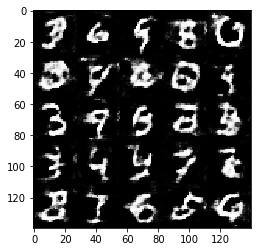

Epoch 1/2... Discriminator Loss: 0.6582... Generator Loss: 2.8787
Epoch 1/2... Discriminator Loss: 0.8792... Generator Loss: 1.2297
Epoch 1/2... Discriminator Loss: 1.0049... Generator Loss: 1.0439
Epoch 1/2... Discriminator Loss: 0.8458... Generator Loss: 1.5712
Epoch 1/2... Discriminator Loss: 0.7975... Generator Loss: 1.8524


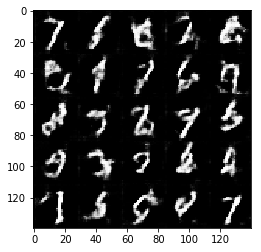

Epoch 1/2... Discriminator Loss: 0.8387... Generator Loss: 2.1026
Epoch 2/2... Discriminator Loss: 0.7271... Generator Loss: 1.5167
Epoch 2/2... Discriminator Loss: 0.7742... Generator Loss: 1.8696
Epoch 2/2... Discriminator Loss: 0.8774... Generator Loss: 1.8019
Epoch 2/2... Discriminator Loss: 0.7476... Generator Loss: 2.1847


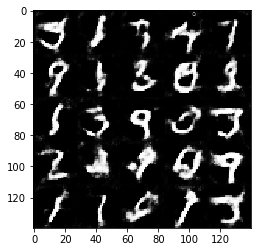

Epoch 2/2... Discriminator Loss: 0.6288... Generator Loss: 2.1300
Epoch 2/2... Discriminator Loss: 0.8030... Generator Loss: 1.7158
Epoch 2/2... Discriminator Loss: 0.7463... Generator Loss: 1.6395
Epoch 2/2... Discriminator Loss: 0.8033... Generator Loss: 1.4510
Epoch 2/2... Discriminator Loss: 0.8215... Generator Loss: 1.7143


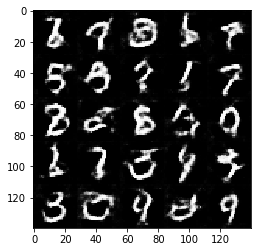

Epoch 2/2... Discriminator Loss: 0.6738... Generator Loss: 1.8925
Epoch 2/2... Discriminator Loss: 0.6967... Generator Loss: 1.8650
Epoch 2/2... Discriminator Loss: 0.7413... Generator Loss: 1.6671
Epoch 2/2... Discriminator Loss: 0.7161... Generator Loss: 1.9530
Epoch 2/2... Discriminator Loss: 0.8005... Generator Loss: 2.3322


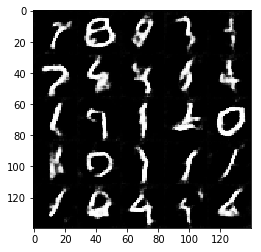

Epoch 2/2... Discriminator Loss: 0.6812... Generator Loss: 1.8621
Epoch 2/2... Discriminator Loss: 0.8275... Generator Loss: 1.4897
Epoch 2/2... Discriminator Loss: 0.7712... Generator Loss: 1.5712
Epoch 2/2... Discriminator Loss: 0.8114... Generator Loss: 1.9835
Epoch 2/2... Discriminator Loss: 0.9426... Generator Loss: 1.3375


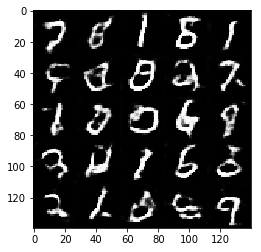

Epoch 2/2... Discriminator Loss: 1.1629... Generator Loss: 0.8847
Epoch 2/2... Discriminator Loss: 0.7427... Generator Loss: 1.6266
Epoch 2/2... Discriminator Loss: 0.8174... Generator Loss: 1.2529
Epoch 2/2... Discriminator Loss: 0.7460... Generator Loss: 1.6170
Epoch 2/2... Discriminator Loss: 0.9162... Generator Loss: 1.0871


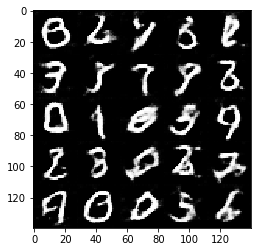

Epoch 2/2... Discriminator Loss: 0.8214... Generator Loss: 1.6448
Epoch 2/2... Discriminator Loss: 0.6538... Generator Loss: 1.7305
Epoch 2/2... Discriminator Loss: 0.7093... Generator Loss: 1.5305
Epoch 2/2... Discriminator Loss: 0.6472... Generator Loss: 1.7131
Epoch 2/2... Discriminator Loss: 0.7702... Generator Loss: 1.4822


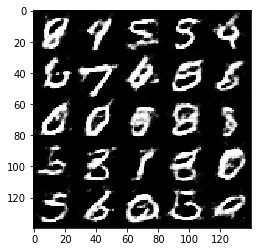

Epoch 2/2... Discriminator Loss: 0.6712... Generator Loss: 1.8904
Epoch 2/2... Discriminator Loss: 0.6690... Generator Loss: 1.7241
Epoch 2/2... Discriminator Loss: 0.7416... Generator Loss: 1.6773
Epoch 2/2... Discriminator Loss: 0.7420... Generator Loss: 1.4091
Epoch 2/2... Discriminator Loss: 0.6916... Generator Loss: 2.2780


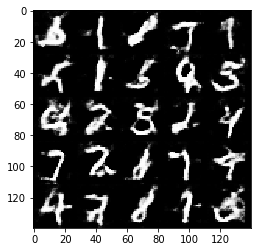

Epoch 2/2... Discriminator Loss: 0.7710... Generator Loss: 1.4557
Epoch 2/2... Discriminator Loss: 0.6510... Generator Loss: 1.6981
Epoch 2/2... Discriminator Loss: 0.5824... Generator Loss: 2.3980
Epoch 2/2... Discriminator Loss: 0.8080... Generator Loss: 1.2067
Epoch 2/2... Discriminator Loss: 0.7315... Generator Loss: 1.3903


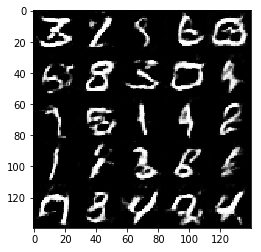

Epoch 2/2... Discriminator Loss: 0.7217... Generator Loss: 1.9532
Epoch 2/2... Discriminator Loss: 0.6477... Generator Loss: 2.0561
Epoch 2/2... Discriminator Loss: 0.6353... Generator Loss: 2.0228
Epoch 2/2... Discriminator Loss: 0.7434... Generator Loss: 2.2574
Epoch 2/2... Discriminator Loss: 1.1519... Generator Loss: 0.8449


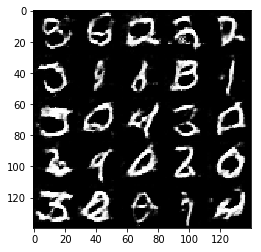

Epoch 2/2... Discriminator Loss: 0.8527... Generator Loss: 1.6516
Epoch 2/2... Discriminator Loss: 0.6496... Generator Loss: 2.0667
Epoch 2/2... Discriminator Loss: 0.7283... Generator Loss: 1.5616


In [13]:
batch_size = 64
z_dim = 100
learning_rate = .0001
beta1 = 0.8


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 3.5560... Generator Loss: 0.3492
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 2.9014
Epoch 1/1... Discriminator Loss: 0.5849... Generator Loss: 3.8871
Epoch 1/1... Discriminator Loss: 0.4094... Generator Loss: 4.5410
Epoch 1/1... Discriminator Loss: 1.7419... Generator Loss: 0.3917


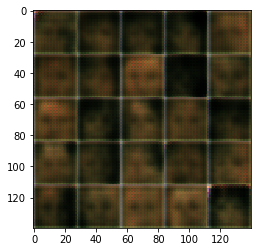

Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 1.0577
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.1697... Generator Loss: 0.9304
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.7929
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.8148


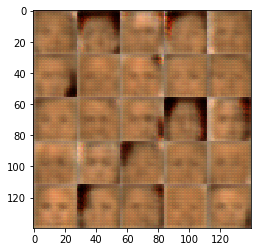

Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 1.1316
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.5223
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.7314


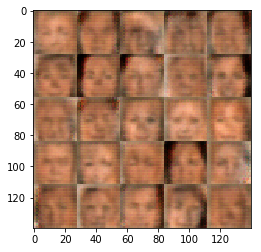

Epoch 1/1... Discriminator Loss: 1.5068... Generator Loss: 1.2360
Epoch 1/1... Discriminator Loss: 4.4703... Generator Loss: 5.2061
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 1.0940


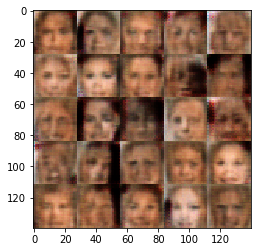

Epoch 1/1... Discriminator Loss: 1.4995... Generator Loss: 0.8636
Epoch 1/1... Discriminator Loss: 0.9622... Generator Loss: 0.8940
Epoch 1/1... Discriminator Loss: 1.3227... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.0081... Generator Loss: 1.1493
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 1.0554


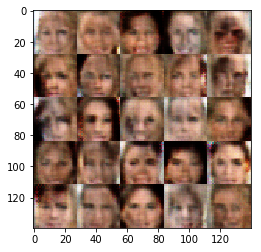

Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.2458... Generator Loss: 0.8031
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.7477
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.9636


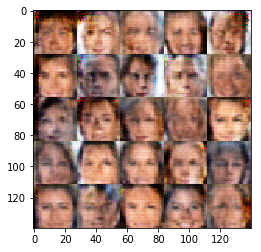

Epoch 1/1... Discriminator Loss: 1.0906... Generator Loss: 0.9825
Epoch 1/1... Discriminator Loss: 1.7306... Generator Loss: 1.3714
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.9877
Epoch 1/1... Discriminator Loss: 1.5287... Generator Loss: 0.8174
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.6722


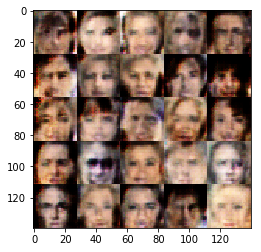

Epoch 1/1... Discriminator Loss: 0.9096... Generator Loss: 2.6631
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.5264
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 1.2805
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.4835


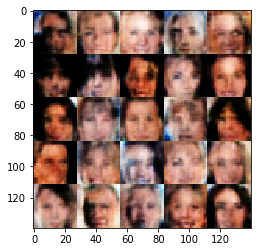

Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.4864
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 1.7087
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.7802... Generator Loss: 0.3122


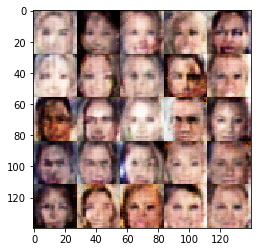

Epoch 1/1... Discriminator Loss: 1.4994... Generator Loss: 1.6656
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.9830
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 1.5092... Generator Loss: 1.5766


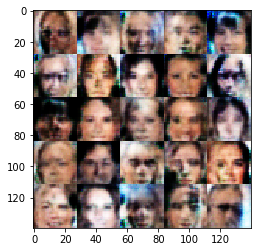

Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 1.8689
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 1.2809
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 0.7696
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.9369


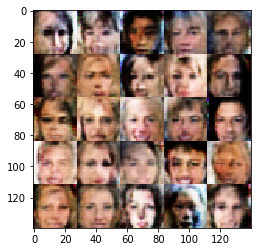

Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.5509
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.9450
Epoch 1/1... Discriminator Loss: 1.5973... Generator Loss: 0.3917
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.9393


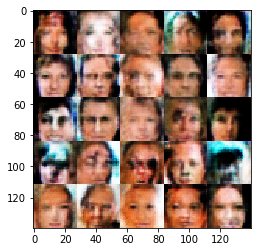

Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.5273
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.9461... Generator Loss: 1.5114
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 1.0527


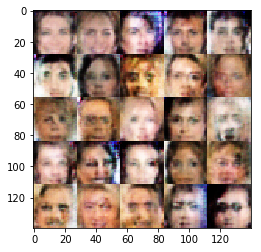

Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 1.2062
Epoch 1/1... Discriminator Loss: 1.4809... Generator Loss: 0.8434
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.5176
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 0.9966


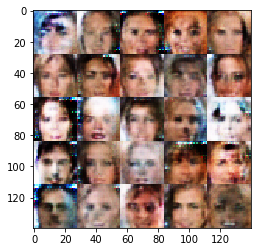

Epoch 1/1... Discriminator Loss: 1.6274... Generator Loss: 1.3758
Epoch 1/1... Discriminator Loss: 1.2879... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.3556... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 0.9186
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.5579


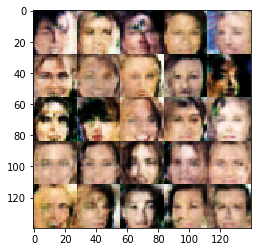

Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.5527
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.5385
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.5862


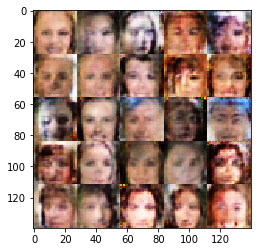

Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.8373
Epoch 1/1... Discriminator Loss: 1.3885... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 1.0853


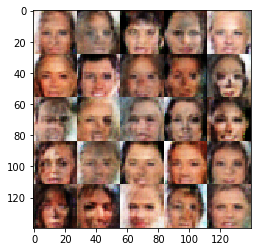

Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.1488... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.5416
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.5218
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.5312


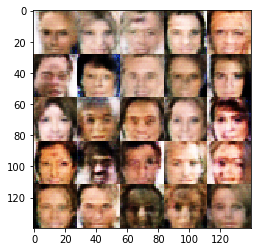

Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 1.0689
Epoch 1/1... Discriminator Loss: 1.2820... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.7358


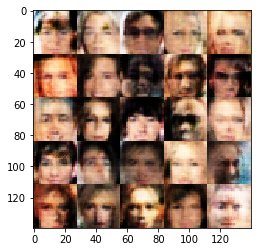

Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.4868
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 1.2125... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.6548


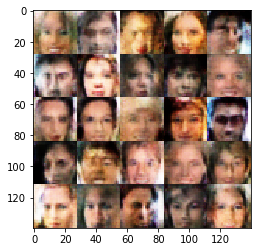

Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 1.3064
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 1.1140
Epoch 1/1... Discriminator Loss: 1.2682... Generator Loss: 0.9293


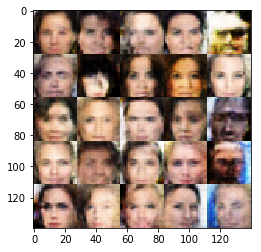

Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 1.5653... Generator Loss: 1.1921
Epoch 1/1... Discriminator Loss: 1.1395... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 1.0267
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.7516


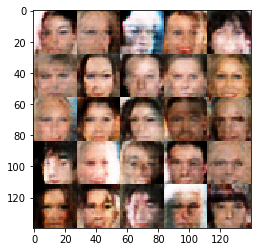

Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.2956... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.9519
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7696


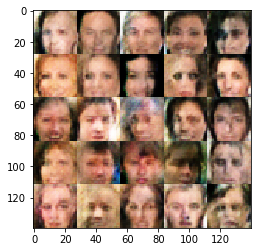

Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.5114
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.9497
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.8707
Epoch 1/1... Discriminator Loss: 1.4487... Generator Loss: 0.6976


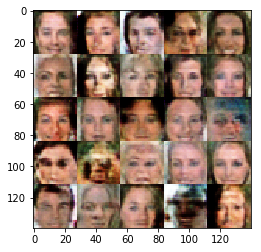

Epoch 1/1... Discriminator Loss: 1.2797... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.4872... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.5598... Generator Loss: 0.5047
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.4675... Generator Loss: 0.4554


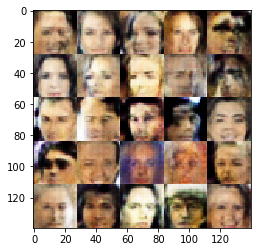

Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.5700
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 1.1018
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 1.4562... Generator Loss: 0.5045


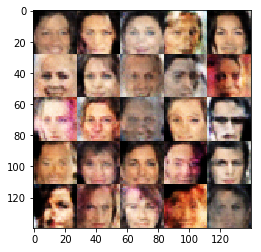

Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.8649
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.9525
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 0.9186


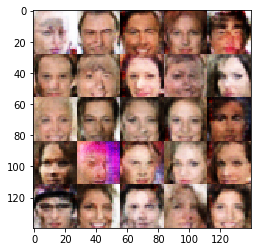

Epoch 1/1... Discriminator Loss: 1.6037... Generator Loss: 1.3790
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 1.2993
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 1.1262
Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.5969


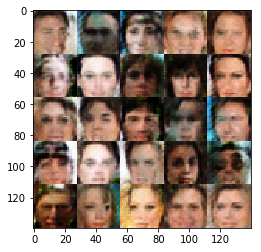

Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.9885


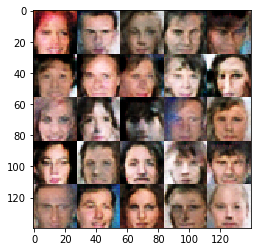

Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 1.1157
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.8869
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.5046
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.6403


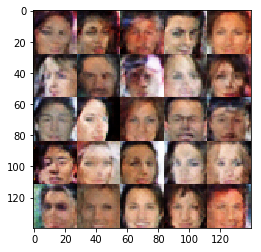

Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.2271... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.5622


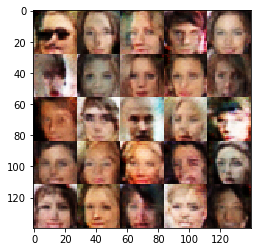

Epoch 1/1... Discriminator Loss: 1.5504... Generator Loss: 0.4919
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.5119


In [14]:
batch_size = 64
z_dim = 100
learning_rate = .0007
beta1 = .4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.